# Example: Solving an Ordinary Differential Equation in Python
In this notebook, we numerically solve the following SIS model using Python. 
\begin{align}
\frac{dS}{dt}&=-\beta S I + \alpha I\\
\frac{dI}{dt}&=\beta S I - \alpha  I\\
\end{align}
with the initial conditions $S(0)=S_0,~I(0)=I_0$.


Later, you will add some additional cells to this notebook to numerically solve the following SIR model.
\begin{align}
\frac{dS}{dt}&=-\beta S I \\
\frac{dI}{dt}&=\beta S I - \alpha  I\\
\frac{dR}{dt}&= \alpha I 
\end{align}
with the initial conditions $S(0)=S_0,~I(0)=I_0,~R(0)=R_0$.




To solve the ODE numerically and plot its solutions, we need to load to Python modules.  We do this using 'import'. When we write, for example, 'import numpy as np', this means we are importing the module called 'numpy', but we will be able to access its functions, etc., using the shorthand 'np'.  For example, if I want to create a numpy array, I can write np.array instead of numpy.array.

*Task 1: Look up the following modules to get an idea for what they will be used for.

In [1]:
import numpy as np
import sympy as sm

import scipy as sp
from scipy.integrate import solve_ivp

import matplotlib as mp
import matplotlib.pyplot as plt

%matplotlib inline
# enable pretty printing of equations
sm.init_printing()

First, we need to create a function that solves our ODE for a given set of parameters.  In the following cell, we define a function that computes the derivatives dS/dt and dI/dt that define the SIR model. The Python function 'def' is used to define your own functions.

In [2]:
# Define model equations in function dydt.  
# It returns, as an array, the values of the RHS of the ODE at (t,y).
def dydt(t, y, par):
                
    alpha = par[0]
    beta  = par[1]

    S = y[0]
    I = y[1]
    R = y[2]
    
    dS =  -beta*S*I 
    dI = beta*S*I - alpha*I
    dR = alpha*I
    
    return np.array([dS,dI,dR])

In the following cell, we define a function 'SolveModel' that numerically solves the model.
The inputs to this function are:
1. array of parameter values, par.
2. range over which to compute the solution, tspan.
3. array of intial conditions, init_cond
4. array of timepoints at which to output the solution.

The function returns the solution to the ODE, which is numerically computed using the function 'solve_ivp'.

In [3]:
def SolveModel(par,tspan,init_cond,t_eval):
    
    ode_soln = solve_ivp(dydt,
                         tspan,
                         init_cond,
                         t_eval = t_eval,
                         args = (par,))
    return ode_soln

In [7]:
help(solve_ivp)

Help on function solve_ivp in module scipy.integrate._ivp.ivp:

solve_ivp(fun, t_span, y0, method='RK45', t_eval=None, dense_output=False, events=None, vectorized=False, **options)
    Solve an initial value problem for a system of ODEs.
    
    This function numerically integrates a system of ordinary differential
    equations given an initial value::
    
        dy / dt = f(t, y)
        y(t0) = y0
    
    Here t is a one-dimensional independent variable (time), y(t) is an
    n-dimensional vector-valued function (state), and an n-dimensional
    vector-valued function f(t, y) determines the differential equations.
    The goal is to find y(t) approximately satisfying the differential
    equations, given an initial value y(t0)=y0.
    
    Some of the solvers support integration in the complex domain, but note that
    for stiff ODE solvers, the right-hand side must be complex-differentiable
    (satisfy Cauchy-Riemann equations [11]_). To solve a problem in the complex
    doma

To numerically compute the solution to our ODE, we need to set numeric values to the initial conditions and the model parameters.

In [5]:
# Define parameters
beta = 0.002 #np.array ([0.0018, 0.0021, 0.0019, 0.0027, 0.0029, 0.0020, 0.0016, 0.0015, 0.0023, 0.0030])
alpha = 0.476
par = [alpha,beta]
    
# Define initial conditions
N0 = 763
I0 = 25
R0 = 0
S0 = N0 - I0 - R0
init_cond = np.array([S0, I0, R0])
tspan = (3,50)    
t_eval = np.linspace(3., 50., 100)

Now, we're ready to numerically solve our system of ODEs using the initial data and parameter values defined in the previous cell. The output of SolveModel is called a 'bunch object'.  The object's contents, which are the output times 't' and an array 'y' of the numerical solution at each time (each column of this array corresponds to a different state variable, in our case, $S$ and $I$). These outputs are "dot-accessible"; that is, they can be accessed using soln.t and soln.y as shown below. 

In [6]:
soln = SolveModel(par,tspan,init_cond,t_eval)
t = soln.t
S = soln.y[0]
I = soln.y[1]
R = soln.y[2]

/Users/prosper/miniconda3/envs/python3/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `args`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


TypeError: dydt() missing 1 required positional argument: 'par'

We can now plot the solutions to the SIR model.

No handles with labels found to put in legend.


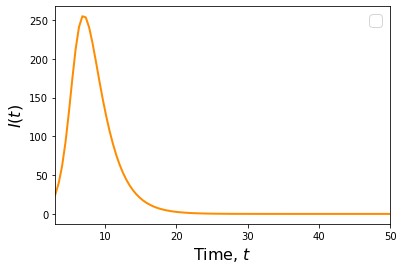

In [8]:
plt.plot(t, I, c='darkorange',  linewidth=2,)
plt.legend(fontsize=16)
    
xmin = t[0]
xmax = t[-1]
plt.xlim(xmin, xmax)
    
xmin = t[0]
xmax = t[-1]
plt.xlim(xmin, xmax)
    
plt.xlabel("Time, $t$", fontsize=16)
plt.ylabel("$I(t)$",fontsize=16)

# NOTE: if you want to save a figure, you can do so as follows.
plt.savefig('SIRplot_test.png')

# Fitting SIR Model to Boarding School Data
We first need to define an objective function to be minimized.  For now, we will define this objective function to be the sum of squared residuals (SSR) $\sum_{i=1}^n (I(t_i,\theta)) - d(t_i))^2$, where $I(t)$ is the number of infected individuals from the ODE solution at time $t$, and $d(t)$ is the number of infected individuals at time $t$ from the data. Note that the solution to the ODE depends on the parameters $\theta=(\beta,\alpha)$. Our goal is to find the parameter vector $\theta$ that minimized the SSR. Later on, we will consider other types of objective functions.

In [15]:
# We need to be able to pass in the parameters, the time data, and the infected count data
def objective_fun(par,tdat,ydat,init_cond): 
    
    par = np.abs(par)
    
    tspan = (tdat[0],tdat[-1]);
    t_eval = tdat;
    
    # Solve the model with the parameters in par
    soln = SolveModel(par,tspan,init_cond,t_eval)
    
    
    # Extract the solution for the number infected over time
    I = soln.y[1]
            
    # Compute the SSR
    SSR = np.sum((I-ydat)**2)

    # Return the SSR for this parameter set and data.
    return SSR

The following code will allow us to minimize the objective function defined in 'objective_fun'. First, we need to import the function scipy.optimize as optimize from the scipy module.

In [9]:
# import scipy as sp
# from scipy.integrate import solve_ivp
import scipy.optimize as optimize

Define arrays for the time (tdata) and infected count data (ydata).

In [11]:
tdata = np.array([1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
ydata = np.array([3, 25, 75, 227, 296, 258, 236, 192, 126, 71, 28, 11, 7])
    

In [1]:
p0 = [.1,.007]#par 

# Define initial conditions
N0 = 763
I0 = ydata[0]
R0 = 0
S0 = N0 - I0 - R0
init_cond = np.array([S0, I0, R0])

# meth = 'Nelder-Mead'
meth = 'BFGS'

    
optimizer = optimize.minimize(objective_fun, p0, args=(tdata,ydata,init_cond), method=meth,disp=True)
best_par = optimizer.x

tspan_new = (tdata[0],tdata[-1])
fit_soln = SolveModel(best_par,tspan_new,init_cond,tdata)

plt.plot(fit_soln.t,fit_soln.y[1])
plt.plot(tdata,ydata,'.')

best_par,p0

NameError: name 'ydata' is not defined

*Task 4: Select a data fitting example from Ch. 6.  In the cells below, or in a new Jupyter notebook, modify the code to fit the model to the given data.  What parameter estimates do you obtain?

In [11]:
help(optimize.minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where x is an 1-D array with shape (n,) and `args`
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where 'n' is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see here) <op